In [1]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf 
from sklearn.preprocessing import MinMaxScaler

In [2]:
data_source = 'alphavantage' # alphavantage or kaggle

if data_source == 'alphavantage':
    # ====================== Loading Data from Alpha Vantage ==================================

    api_key = 'BG2B86JAZ8KZD79R'

    # American Airlines stock market prices
    ticker = "AAL"

    # JSON file with all the stock market data for AAL from the last 20 years
    url_string = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=%s&outputsize=full&apikey=%s"%(ticker,api_key)

    # Save data to this file
    file_to_save = 'stock_market_data-%s.csv'%ticker

    # If you haven't already saved data,
    # Go ahead and grab the data from the url
    # And store date, low, high, volume, close, open values to a Pandas DataFrame
    if not os.path.exists(file_to_save):
        with urllib.request.urlopen(url_string) as url:
            data = json.loads(url.read().decode())
            # extract stock market data
            data = data['Time Series (Daily)']
            df = pd.DataFrame(columns=['Date','Low','High','Close','Open'])
            for k,v in data.items():
                date = dt.datetime.strptime(k, '%Y-%m-%d')
                data_row = [date.date(),float(v['3. low']),float(v['2. high']),
                            float(v['4. close']),float(v['1. open'])]
                df.loc[-1,:] = data_row
                df.index = df.index + 1
        print('Data saved to : %s'%file_to_save)        
        df.to_csv(file_to_save)

    # If the data is already there, just load it from the CSV
    else:
        print('File already exists. Loading data from CSV')
        df = pd.read_csv(file_to_save)



Data saved to : stock_market_data-AAL.csv


In [4]:
# Sort DataFrame by date
df = df.sort_values('Date')

# Double check the result
df.head()


,Date,Low,High,Close,Open
0,2005-09-27,19.1,21.4,19.3,21.05
1,2005-09-28,19.2,20.53,20.5,19.3
2,2005-09-29,20.1,20.58,20.21,20.4
3,2005-09-30,20.18,21.05,21.01,20.26
4,2005-10-03,20.9,21.75,21.5,20.9


In [5]:
df.tail()

,Date,Low,High,Close,Open
4296,2022-10-20,13.425,14.27,13.46,13.95
4297,2022-10-21,13.21,13.865,13.71,13.36
4298,2022-10-24,13.585,14.12,14.1,13.75
4299,2022-10-25,13.93,14.37,14.29,14.05
4300,2022-10-26,13.9901,14.44,14.0,14.14


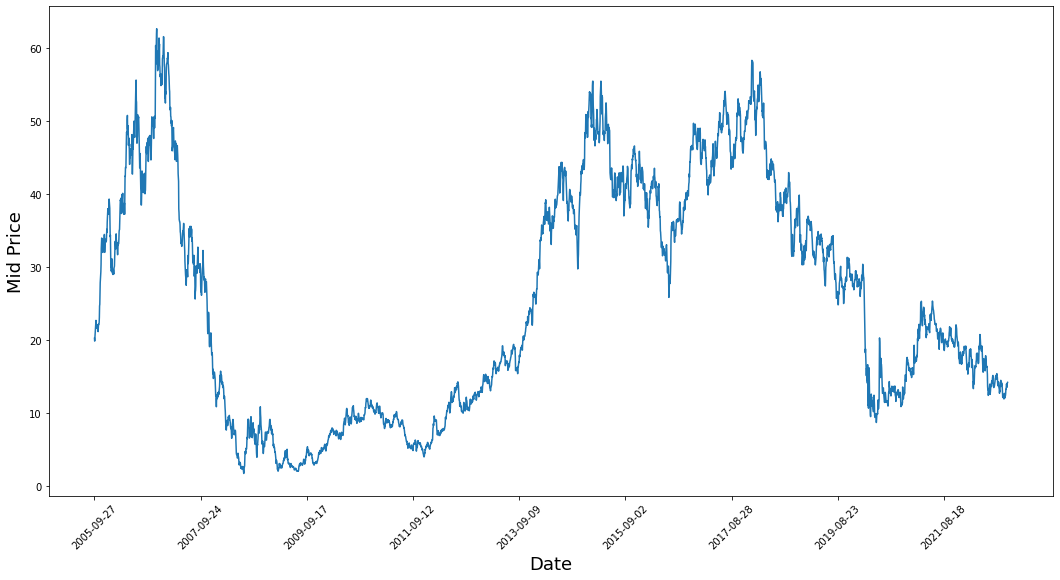

In [6]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()


In [8]:
# First calculate the mid prices from the highest and lowest
high_prices = df.loc[:,'High'].to_numpy()
low_prices = df.loc[:,'Low'].to_numpy()
mid_prices = (high_prices+low_prices)/2.0


In [9]:
train_data = mid_prices[:11000]
test_data = mid_prices[11000:]


In [10]:
# Scale the data to be between 0 and 1
# When scaling remember! You normalize both test and train data with respect to training data
# Because you are not supposed to have access to test data
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)


In [11]:
# Train the Scaler with training data and smooth data
smoothing_window_size = 2500
for di in range(0,10000,smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

# You normalize the last bit of remaining data
scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])


ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by MinMaxScaler.